In [29]:
from torchvision.transforms import v2
from torchvision import tv_tensors
from PIL import Image
import numpy as np
import torch

from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert

from matplotlib import pyplot as plt

In [30]:
image_path = '../data/images/IMG_20241216_153829.jpg'
label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
image = Image.open(image_path)

yolo_boxes = []
yolo_classes = []
with open(label_path, 'r') as f:
    line = f.readline()
    while line:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        yolo_boxes.append([x_center, y_center, width, height])
        yolo_classes.append([class_id])
        line = f.readline()

W, H = image.size

In [31]:
np.array(image).shape

(2016, 4032, 3)

In [32]:
torch_image = torch.from_numpy(np.array(image).transpose(2, 0, 1))
torch_image.shape

torch.Size([3, 2016, 4032])

In [33]:
tv_boxes = torch.from_numpy(np.array(yolo_boxes).copy())
tv_boxes[:, [0, 2]] *= W
tv_boxes[:, [1, 3]] *= H

In [34]:
tv_boxes_xyxy = box_convert(tv_boxes, in_fmt='xywh', out_fmt='xyxy')

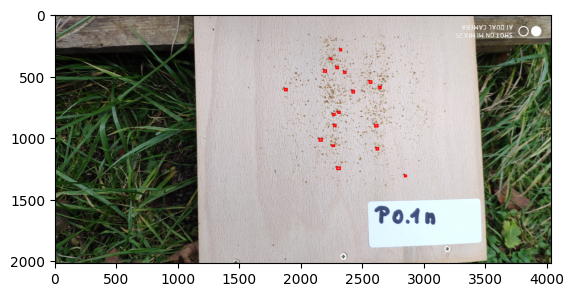

In [35]:
dbb = draw_bounding_boxes(torch_image, tv_boxes_xyxy, labels=None, colors='red', fill=True, width=10)
plt.imshow(dbb.numpy().transpose(1, 2, 0))

In [36]:
transform = v2.Compose([
    v2.RandomIoUCrop(min_scale=0.0001),
    v2.Resize((512, 512)),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomVerticalFlip(0.5),
    v2.ColorJitter(),
    v2.ToDtype(torch.float32, scale=True)
])

In [37]:
tvt_image = tv_tensors.Image(torch_image)
tvt_boxes = tv_tensors.BoundingBoxes(tv_boxes, format='XYWH', canvas_size=torch_image.shape[-2:], dtype=torch.float32)

In [38]:
trafo_image, trafo_boxes = transform(tvt_image, tvt_boxes)
sane_boxes = v2.SanitizeBoundingBoxes()({'labels':trafo_boxes})

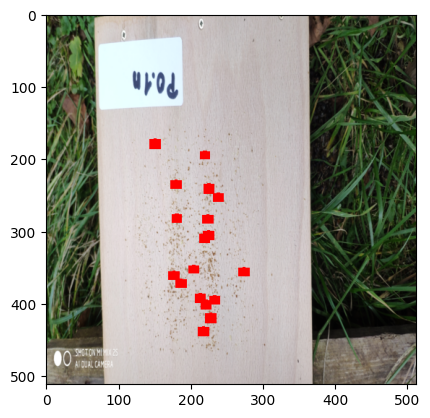

In [39]:
trafo_boxes_xyxy = box_convert(sane_boxes['labels'], in_fmt='xywh', out_fmt='xyxy')
dbb = draw_bounding_boxes(trafo_image, trafo_boxes_xyxy, labels=None, colors='red', fill=True, width=10)
plt.imshow(dbb.numpy().transpose(1, 2, 0))